# Sheet 09: Time-evolution of a one-qubit Hamiltonian

In [1]:
from qiskit import *
from qiskit_aer import Aer
import numpy as np
import matplotlib.pyplot as plt

# 2. Time-evolution using Euler decomposition

To apply
$$\hat{U}(t) = e^{i\phi}e^{i\alpha\hat{Z}}e^{i\beta\hat{Y}}e^{i\gamma\hat{Z}}$$
on a single-qubit state
$$|\psi(t=0)\rangle=|0\rangle$$
we can make use of the RZ and RY Qiskit gates:
$$RY(\theta) = exp(-i\frac{\theta}{2}Y),\qquad RZ(\theta) = exp(-i\frac{\theta}{2}Z)$$

In [2]:
def time_evo(qc, t, cE=1, cB=1):
    eta = np.sqrt(cE**2+cB**2)
    if t==0:
        gamma = 0
    else:
        gamma = np.arctan(-eta/(cE*np.tan(eta*t/2)))/2
    alpha = gamma + np.pi/2
    beta = np.arcsin(cB/eta*np.sin(eta*t/2))

    qc = qc.copy()
    qc.rz(-2*gamma, 0)
    qc.ry(-2*beta, 0)
    qc.rz(-2*alpha, 0)
    qc.measure(0,0)
    
    return qc

# 3. survival probability 

The survival probability $P_0(t)$  can be obtained by applying $U(t)$ at different time steps and measuring the fraction of measurements '0'.

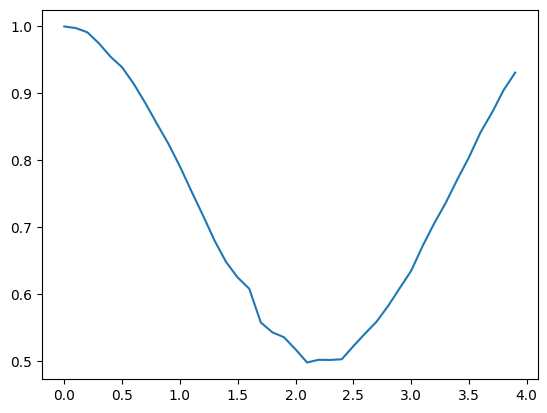

In [3]:
def survival_exact(time, steps):
    p0 = []
    times = []

    #physical parameters
    cE = 1
    cB = 1

    #simulation parameters
    simulator = Aer.get_backend('qasm_simulator')
    tot_shots=1e4

    #initial state in |0>
    qc = QuantumCircuit(1,1)

    for t in range(steps):
        evolved_circuit = time_evo(qc, t*(time/steps), cE=cE, cB=cB)
        trans_circuit = transpile(evolved_circuit, backend=simulator)
        job = simulator.run(trans_circuit, shots=tot_shots)
        counts = job.result().get_counts(evolved_circuit)
        p0.append(counts['0']/tot_shots)
        times.append((time/steps)*t)
    return np.array(p0), times

p0, times = survival_exact(4, 40) 
plt.plot(times, p0, label='Survival probability')

# 4. Time-evolution using Trotterization

At leading order, the Trotter expansion of our evolution operator is just the product of the single exponential operators
$$U_{LO}(\Delta_t) = e^{-i(\frac{c_e}{2}+c_B)\Delta_t\hat{I}}e^{i\frac{c_B}{2}\Delta_t\hat{X}}e^{i\frac{c_E}{2}\Delta_t\hat{Z}}+\mathcal{O}(\Delta_t^2)$$

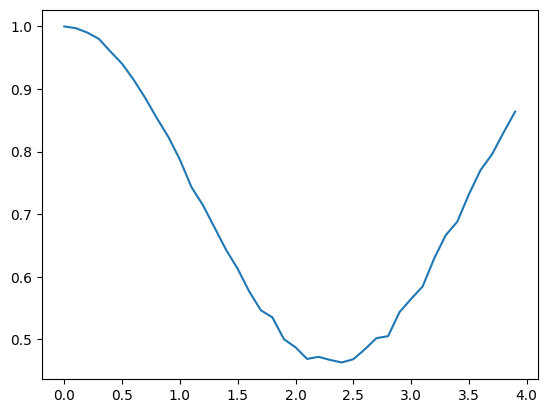

In [8]:
def survival_trotter(time, steps, trotter_steps):
    def trotter_evo(qc, delta_t, cE=1, cB=1):
        qc.rz(-cE*delta_t, 0)
        qc.rx(-cB*delta_t, 0)

        return qc



    p0 = []
    times = []

    #physical parameters
    cE = 1
    cB = 1

    #simulation parameters
    simulator = Aer.get_backend('qasm_simulator')
    tot_shots=1e4

    #initial state in |0>
    qc = QuantumCircuit(1,1)

    for j in range(steps):
        t = (time/steps)*j
        evolved_circuit = qc.copy()
        for _ in range(trotter_steps):
            evolved_circuit = trotter_evo(evolved_circuit, t/trotter_steps, cE=cE, cB=cB)
        meas_circuit = evolved_circuit.copy()
        meas_circuit.measure(0,0)
        trans_circuit = transpile(meas_circuit, backend=simulator)
        job = simulator.run(trans_circuit, shots=tot_shots)
        counts = job.result().get_counts(meas_circuit)
        p0.append(counts['0']/tot_shots)
        times.append(t)

    return np.array(p0), times

p0, times = survival_trotter(4, 40, 3)
plt.plot(times, p0, label='Survival probability')

# 4. c) compare the results for different numbers of steps

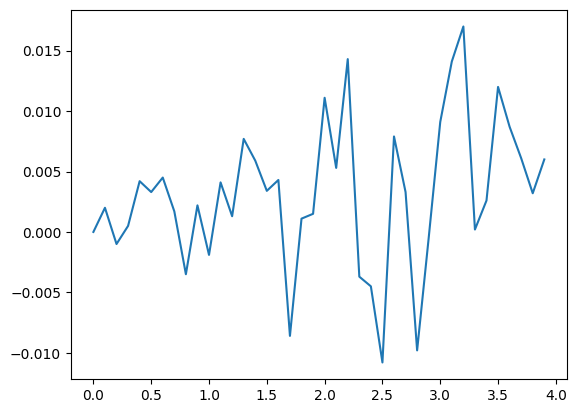

In [10]:
Ns = 10
p0_exact, times = survival_exact(4,40)
p0_trotter, times = survival_trotter(4,40,Ns)
delta_p0 = p0_exact - p0_trotter

plt.plot(times, delta_p0, label='Delta P0')

With larger $N_s$ the $\Delta P_0$ gets closer to 0, meaning that smaller time steps produce a result closer to the exact one.